In [1]:
import pygame
import random
import numpy as np
from enum import Enum
from collections import namedtuple

pygame 2.6.0 (SDL 2.28.4, Python 3.10.14)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
pygame.init()
# font = pygame.font.Font('arial.ttf', 25)
font = pygame.font.SysFont('arial', 25)

class Direction(Enum):
    RIGHT = 1
    LEFT = 2
    UP = 3
    DOWN = 4

Point = namedtuple('Point', 'x, y')

# rgb colors
WHITE = (255, 255, 255)
RED = (200,0,0)
BLUE1 = (0, 0, 255)
BLUE2 = (0, 100, 255)
BLACK = (0,0,0)

BLOCK_SIZE = 20
SPEED = 40

class SnakeGame:

    def __init__(self, w=640, h=480):
        self.w = w
        self.h = h
        # init display
        self.display = pygame.display.set_mode((self.w, self.h))
        pygame.display.set_caption('Snake')
        self.clock = pygame.time.Clock()
        self.reset()


    def reset(self):
        # init game state
        self.direction = Direction.RIGHT

        self.head = Point(self.w/2, self.h/2)
        self.snake = [self.head,
                      Point(self.head.x-BLOCK_SIZE, self.head.y),
                      Point(self.head.x-(2*BLOCK_SIZE), self.head.y)]

        self.score = 0
        self.food = None
        self._place_food()
        self.frame_iteration = 0


    def _place_food(self):
        x = random.randint(0, (self.w-BLOCK_SIZE )//BLOCK_SIZE )*BLOCK_SIZE
        y = random.randint(0, (self.h-BLOCK_SIZE )//BLOCK_SIZE )*BLOCK_SIZE
        self.food = Point(x, y)
        if self.food in self.snake:
            self._place_food()


    def play_step(self, action):
        self.frame_iteration += 1
        # 1. collect user input
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                quit()
        
        # 2. move
        self._move(action) # update the head
        self.snake.insert(0, self.head)
        
        # 3. check if game over
        reward = 0
        game_over = False
        if self.is_collision() or self.frame_iteration > 100*len(self.snake):
            game_over = True
            reward = -10
            return reward, game_over, self.score

        # 4. place new food or just move
        if self.head == self.food:
            self.score += 1
            reward = 10
            self._place_food()
        else:
            self.snake.pop()
        
        # 5. update ui and clock
        self._update_ui()
        self.clock.tick(SPEED)
        # 6. return game over and score
        return reward, game_over, self.score


    def is_collision(self, pt=None):
        if pt is None:
            pt = self.head
        # hits boundary
        if pt.x > self.w - BLOCK_SIZE or pt.x < 0 or pt.y > self.h - BLOCK_SIZE or pt.y < 0:
            return True
        # hits itself
        if pt in self.snake[1:]:
            return True

        return False


    def _update_ui(self):
        self.display.fill(BLACK)

        for pt in self.snake:
            pygame.draw.rect(self.display, BLUE1, pygame.Rect(pt.x, pt.y, BLOCK_SIZE, BLOCK_SIZE))
            pygame.draw.rect(self.display, BLUE2, pygame.Rect(pt.x+4, pt.y+4, 12, 12))

        pygame.draw.rect(self.display, RED, pygame.Rect(self.food.x, self.food.y, BLOCK_SIZE, BLOCK_SIZE))

        text = font.render("Score: " + str(self.score), True, WHITE)
        self.display.blit(text, [0, 0])
        pygame.display.flip()


    def _move(self, action):
        # [straight, right, left]

        clock_wise = [Direction.RIGHT, Direction.DOWN, Direction.LEFT, Direction.UP]
        idx = clock_wise.index(self.direction)

        if np.array_equal(action, [1, 0, 0]):
            new_dir = clock_wise[idx] # no change
        elif np.array_equal(action, [0, 1, 0]):
            next_idx = (idx + 1) % 4
            new_dir = clock_wise[next_idx] # right turn r -> d -> l -> u
        else: # [0, 0, 1]
            next_idx = (idx - 1) % 4
            new_dir = clock_wise[next_idx] # left turn r -> u -> l -> d

        self.direction = new_dir

        x = self.head.x
        y = self.head.y
        if self.direction == Direction.RIGHT:
            x += BLOCK_SIZE
        elif self.direction == Direction.LEFT:
            x -= BLOCK_SIZE
        elif self.direction == Direction.DOWN:
            y += BLOCK_SIZE
        elif self.direction == Direction.UP:
            y -= BLOCK_SIZE

        self.head = Point(x, y)

In [3]:
import torch
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F 

In [4]:
class Linear_QNet(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.linear2(x)

        return x

In [5]:
class QTrainer:

    def __init__(self, model, lr, gamma):
        self.lr = lr
        self.gamma = gamma
        self.model = model
        self.optimizer = optim.Adam(model.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()

    # we are going through the whole loop such that we can train on the long memory
    def train_step(self, current_state, action, reward, new_state, done):
        current_state = torch.tensor(current_state, dtype=torch.float)
        new_state = torch.tensor(new_state, dtype=torch.float)
        action = torch.tensor(action, dtype=torch.float)
        reward = torch.tensor(reward, dtype=torch.float)

        if len(current_state.shape) == 1:
            current_state = torch.unsqueeze(current_state, 0)
            new_state = torch.unsqueeze(new_state, 0)
            action = torch.unsqueeze(action, 0)
            reward = torch.unsqueeze(reward, 0)
            done = (done, )

        pred = self.model(current_state) # gets 3 different values

        target = pred.clone()
        for index in range(len(done)):
            Q_new = reward[index]
            
            # if the game is not lost
            if not done[index]:
                Q_new = reward[index] + self.gamma * torch.max(self.model(new_state[index]))

            target[index][torch.argmax(action).item()] = Q_new

        self.optimizer.zero_grad()
        loss = self.criterion(target, pred)
        loss.backward()

        self.optimizer.step()


In [6]:
import random
from collections import deque

In [7]:
MAX_MEMORY = 100000
BATCH_SIZE = 1000
LR = 0.001

class Agent:

    def __init__(self):
        self.n_games = 0
        self.epsilon = 0 # controls randomness
        self.gamma = 0.9 # discount rate 
        self.memory = deque(maxlen=MAX_MEMORY) # if exceeds the memory then it will pop the first one (from the left)
        self.model = Linear_QNet(11, 256, 3)
        self.trainer = QTrainer(self.model, LR, self.gamma)

    def get_state(self, game):
        head = game.snake[0]
        point_l = Point(head.x - 20, head.y)
        point_r = Point(head.x + 20, head.y)
        point_u = Point(head.x, head.y - 20)
        point_d = Point(head.x, head.y + 20)
        
        dir_l = game.direction == Direction.LEFT
        dir_r = game.direction == Direction.RIGHT
        dir_u = game.direction == Direction.UP
        dir_d = game.direction == Direction.DOWN

        state = [
            # Danger straight
            (dir_r and game.is_collision(point_r)) or 
            (dir_l and game.is_collision(point_l)) or 
            (dir_u and game.is_collision(point_u)) or 
            (dir_d and game.is_collision(point_d)),

            # Danger right
            (dir_u and game.is_collision(point_r)) or 
            (dir_d and game.is_collision(point_l)) or 
            (dir_l and game.is_collision(point_u)) or 
            (dir_r and game.is_collision(point_d)),

            # Danger left
            (dir_d and game.is_collision(point_r)) or 
            (dir_u and game.is_collision(point_l)) or 
            (dir_r and game.is_collision(point_u)) or 
            (dir_l and game.is_collision(point_d)),
            
            # Move direction
            dir_l,
            dir_r,
            dir_u,
            dir_d,
            
            # Food location 
            game.food.x < game.head.x,  # food left
            game.food.x > game.head.x,  # food right
            game.food.y < game.head.y,  # food up
            game.food.y > game.head.y  # food down
            ]

        return np.array(state, dtype=int)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def train_long_memory(self):
        if len(self.memory) > BATCH_SIZE:
            mini_sample = random.sample(self.memory, BATCH_SIZE) # return list of tuples
        else:
            mini_sample = self.memory

        
        states, actions, rewards, next_states, dones = zip(*mini_sample)
        self.trainer.train_step(states, actions, rewards, next_states, dones)

    def train_short_memory(self, state, action, reward, next_state, done):
        self.trainer.train_step(state, action, reward, next_state, done)

    def get_action(self, state):
        self.epsilon = 80 - self.n_games
        action = [0, 0, 0]

        if random.randint(0, 200) < self.epsilon:
            move = random.randint(0, 2)
            action[move] = 1
        else:
            state0 = torch.tensor(state, dtype=torch.float)
            prediction = self.model(state0)
            move = torch.argmax(prediction).item()
            action[move] = 1

        return action


In [8]:
import matplotlib.pyplot as plt
from IPython import display

plt.ion()

def plot(scores, mean_scores):
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Number of Games')
    plt.ylabel('Score')
    plt.plot(scores)
    plt.plot(mean_scores)
    plt.ylim(ymin=0)
    plt.text(len(scores)-1, scores[-1], str(scores[-1]))
    plt.text(len(mean_scores)-1, mean_scores[-1], str(mean_scores[-1]))
    plt.show(block=False)
    plt.pause(.1)

In [9]:
def train():
    plot_scores = []
    plot_mean_scores = []
    total_score = 0
    record = 0
    agent = Agent()
    game = SnakeGame()

    while True:
        # get current state
        current_state = agent.get_state(game)

        # get the action based on the state (predict)
        action = agent.get_action(current_state)

        # perform action and get the new state
        reward, done, score = game.play_step(action)
        new_state = agent.get_state(game)

        # train on short memory
        agent.train_short_memory(current_state, action, reward, new_state, done)

        # remember for long memory
        agent.remember(current_state, action, reward, new_state, done)

        # the game is done
        if done:
            # train long memory
            game.reset()
            agent.n_games += 1
            agent.train_long_memory()

            if score > record:
                record = score
            
            print(f"Game: {agent.n_games}\t Score: {score}\t Record: {record}")

            plot_scores.append(score)
            total_score += score
            mean_score = total_score / agent.n_games
            plot_mean_scores.append(mean_score)
            plot(plot_scores, plot_mean_scores)


<Figure size 640x480 with 0 Axes>

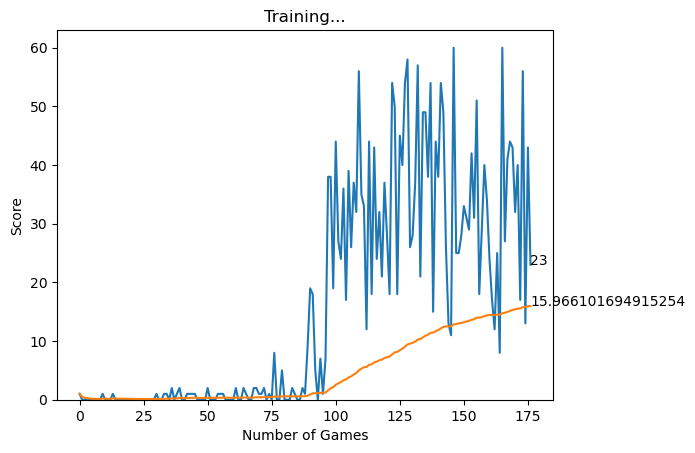

KeyboardInterrupt: 

In [10]:
train()